# Flowers Analysis
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html

102 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 102 different categories. 
The images were acquired by searching the web and taking pictures. There are a
minimum of 40 images for each category.

The images are contained in the file 102flowers.tgz and the image labels in
imagelabels.mat.

We provide 4 distance matrices. D_hsv, D_hog, D_siftint, D_siftbdy. These
are the chi^2 distance matrices used in the publication below.

The database was used in:

Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.

Datasplit
------------------------------------------------
The datasplits used in this paper are specified in setid.mat.

The results in the paper are produced on a 103 category database. The two
categories labeled Petunia have since been merged since they are the same.
There is a training file (trnid), a validation file (valid)
and a testfile (tstid). 

Segmentation Images
------------------------------------------------
We provide the segmentations for the images in the file 102segmentations.tgz

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmenation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback07.(pdf,ps.gz).
.

History
-----------------------------------------------
version 1.1 - Two petunia categories merged into one. 

# Requirements

In [ ]:
from google.colab import drive

from os import listdir
from os.path import isfile, join
import os.path
from os import path

import tarfile
import glob

import tensorflow as tf
import sklearn 
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import scipy
from scipy import io

import PIL
from PIL import Image
import cv2
import seaborn as sns

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
PATH_PROJ = "/content/gdrive/MyDrive/AML-proj/" 
if not path.exists(PATH_PROJ):
    PATH_PROJ = "/content/gdrive/Shareddrives/AML-proj/"  # TODO: check if it is correct!

PATH_JPG = "/content/jpg/"
PATH_TAR = PATH_PROJ + "102flowers.tgz"
IMG_SIZE = 224
NUM_CLASSES = 102

NAMES = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

NAMES_ID = dict(zip(NAMES, [x for x in range(len(NAMES))]))
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

('bird of paradise', 'monkshood', 'globe thistle', 'snapdragon')

# Functions

In [ ]:
def execute_pca_on_imgs(img, show=False):
  # Splitting the image in R,G,B arrays.
  b, g, r = cv2.split(img) 
  #it will split the original image into Blue, Green and Red arrays.

  # it is mandatory to do feature scaling before applying PCA because PCA directions are highly sensitive to the relative ranges of features
  r_scaled = r / 255
  g_scaled = g / 255
  b_scaled = b / 255

  #initialize PCA with at least 95% variance  
  pca_r = PCA(0.95)
  pca_r_trans = pca_r.fit_transform(r_scaled)

  pca_g = PCA(0.95)
  pca_g_trans = pca_g.fit_transform(g_scaled)

  pca_b = PCA(0.95)
  pca_b_trans = pca_b.fit_transform(b_scaled)

  # inverse
  pca_r_org = pca_r.inverse_transform(pca_r_trans)
  pca_g_org = pca_g.inverse_transform(pca_g_trans)
  pca_b_org = pca_b.inverse_transform(pca_b_trans)

  # compressiong
  img_compressed = cv2.merge((pca_b_org, pca_g_org, pca_r_org))
  #viewing the compressed image
  if show: 
    plt.imshow(img_compressed)
    plt.show()

  return img_compressed
    

def execute_pca_on_imgs_set(df, path = PATH_JPG):
  for img_name in df["Id"]:
    RGB_img = plt.imread(path + img_name)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_pca = execute_pca_on_imgs(RGB_img)
    cv2.imwrite(PATH_PROJ + "jpg_pca/" + img_name, 255*im_pca, [cv2.IMWRITE_JPEG_QUALITY])
    

def processing_set(dataset, images, labels, size=224, return_pca=False):
  x, y = [], []
  for num_img in dataset:
    # print(f"linking {num_img} to {images[num_img - 1]}")
    path = PATH_JPG + images[num_img - 1]
    im=cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,(size,size))
    x.append(im)
    y.append(labels[num_img - 1])
  
  if return_pca:
    return execute_pca_on_imgs_set(x), np.asarray(y) 
  else:
    return np.asarray(x), np.asarray(y)


def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


def get_img_info(df, path_figure = PATH_JPG):
  w, h = [], []
  for index, path in enumerate(df["Id"].values):
    im = PIL.Image.open(path_figure+ str(path))
    w.append(im.size[0])
    h.append(im.size[1])

  w, h = np.array(w), np.array(h)
  return int(np.average(w)), int(np.average(h))



## Plot Functions

In [ ]:
def plot_figure(df, path_figure = PATH_JPG):
  plt.figure(figsize=(16,12))
  random_image = df.sample(n=21)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(3,7, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()



def plot_figure_by_class(df, class_number, path_figure = PATH_JPG):
  plt.figure(figsize=(12,8))

  random_image = df[df['Category']==class_number].sample(n=4)
  random_image_paths = random_image['Id'].values
  random_image_cat = random_image['Category'].values

  for index, path in enumerate(random_image_paths):
      im = PIL.Image.open(path_figure+path)
      plt.subplot(1,4, index+1)
      plt.imshow(im)
      plt.title(NAMES[int(random_image_cat[index])])
      plt.axis('off')
  plt.show()


def plot_history(history):
  pd.DataFrame(history.history).plot(
  figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
  style=["r--", "r--.", "b-", "b-*"])
  plt.show()

# Import Data

In [ ]:
!rm -r $PATH_JPG # remove old data

In [ ]:
# Import Dataset
%%capture
!tar -xvf $PATH_TAR -C '/content/'
images = [f for f in listdir(PATH_JPG) if isfile(join(PATH_JPG, f))]
images = sorted(images)

df = pd.DataFrame()
df['Id'] = images
df['Category'] = scipy.io.loadmat(PATH_PROJ + 'imagelabels.mat')['labels'][0] - 1 
df['Category'] = df['Category'].astype(int)
#df.head(5)

In [ ]:
# Split Dataset con le rispettive label
split = scipy.io.loadmat(PATH_PROJ + 'setid.mat')
test_split = split["tstid"][0] - 1 # start from zero
train_split = split["trnid"][0] - 1
valid_split = split["valid"][0] - 1

train_set = df.iloc[train_split]
train_set['Category'].astype(int)
test_set = df.iloc[test_split]
test_set['Category'].astype(int)
val_set = df.iloc[valid_split]
val_set['Category'].astype(int)
print("Train set:", train_set.shape, "   Validation set:", val_set.shape, "   Test set:", test_set.shape)

Train set: (1020, 2)    Validation set: (1020, 2)    Test set: (6149, 2)


# Analisi Dataset

Analizziamo le distribuzioni dei campioni immagini nei vari set in modo da avere una visione generale sul bilanciamento delle classi

## Take a Quick Look at the Data Structure

In [ ]:
display(train_set.head())
train_set.info()

,Id,Category
6764,image_06765.jpg,0
6754,image_06755.jpg,0
6767,image_06768.jpg,0
6735,image_06736.jpg,0
6743,image_06744.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 6764 to 8040
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1020 non-null   object
 1   Category  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
display(test_set.head())
test_set.info()

,Id,Category
6733,image_06734.jpg,0
6734,image_06735.jpg,0
6736,image_06737.jpg,0
6741,image_06742.jpg,0
6742,image_06743.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6149 entries, 6733 to 8046
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6149 non-null   object
 1   Category  6149 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 144.1+ KB


In [ ]:
display(val_set.head())
val_set.info()

,Id,Category
6772,image_06773.jpg,0
6766,image_06767.jpg,0
6738,image_06739.jpg,0
6748,image_06749.jpg,0
6762,image_06763.jpg,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 6772 to 8029
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1020 non-null   object
 1   Category  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
average_resolution = get_img_info(df) # average resolution img

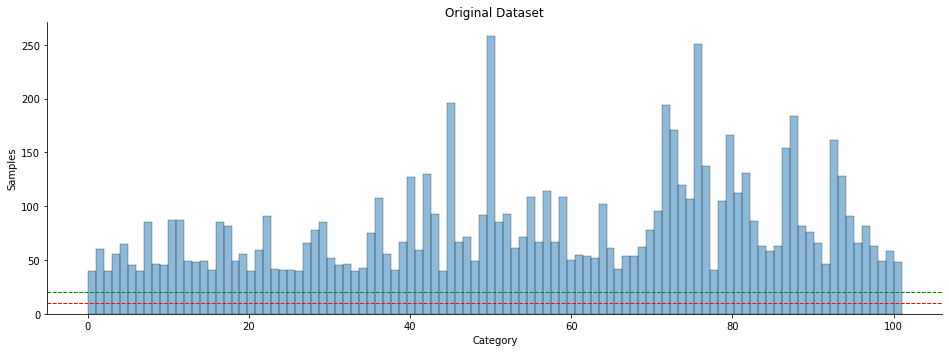

In [ ]:
distribuzione = sns.displot(df, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Original Dataset')

distribuzione.refline(y = 10,
          color = "red",
          lw = 1)
distribuzione.refline(y = 20,
          color = "green",
          lw = 1)

distribuzione.fig.set_size_inches(15,5)

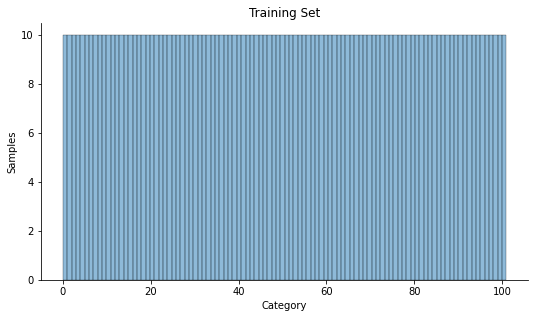

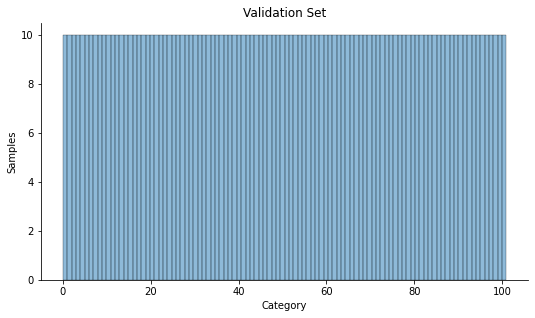

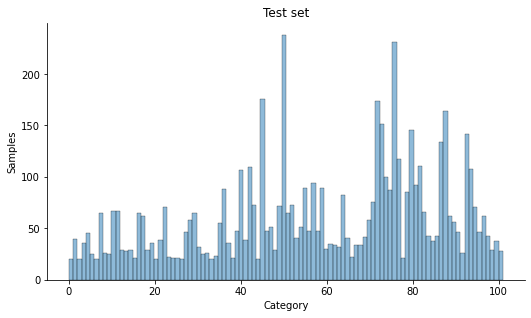

In [ ]:
distribuzione = sns.displot(train_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Training Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(val_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Validation Set')
distribuzione.fig.set_size_inches(8,4)

distribuzione = sns.displot(test_set, bins=102, legend=False).set(xlabel='Category', ylabel='Samples', title='Test set')
distribuzione.fig.set_size_inches(8,4)

In [ ]:
# Classi ordinate per numero di campioni
counts = df['Category'].value_counts()
idx = counts.index.tolist()
count_numbers_of_flowers_by_name = {}
for label_number in idx:
  x = counts[label_number]
  count_numbers_of_flowers_by_name[NAMES[int(label_number)]] = x

count_numbers_of_flowers_by_name = pd.DataFrame(count_numbers_of_flowers_by_name.items(), columns=['Category', 'Samples'])
display(count_numbers_of_flowers_by_name)

# TODO: convert this in csv or latex for documentation

,Category,Samples
0,petunia,258
1,passion flower,251
2,wallflower,196
3,water lily,194
4,watercress,184
...,...,...
97,moon orchid,40
98,bolero deep blue,40
99,mexican aster,40
100,pink primrose,40


## Osservazioni  
Come si può vedere dai grafici le classi nel training/Validation set sono perfettamente ben bilanciate.  
Putroppo però **il numero di campioni (10) per ogni classe è molto basso** per un task di classificazione basato sull'uso di CNN.  

Questo ci fa già riflettere su un  possibile approccio di **Data Augmentation** per poter far fronte a queste carenze di immagini di Training.

## Display Immagini

Ora mostriamo alcune immagini e vediamo come appaiono, per comodità mostriamo un numero ridotto di classi.

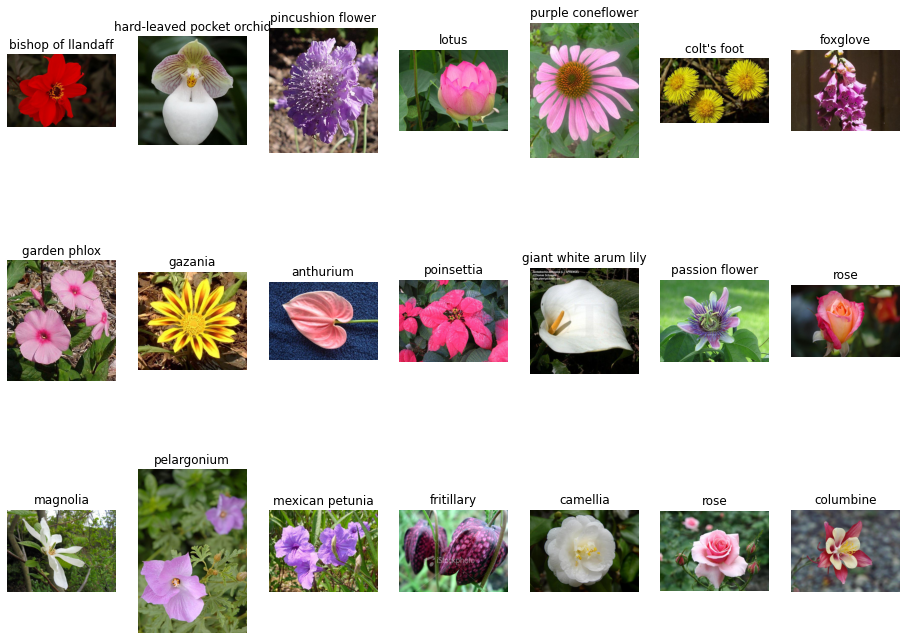

In [ ]:
plot_figure(df)

### Inter Class Similarity 
Osservando le immagini del data set originale abbiamo notato delle similarità tra classi di fiori diverse. Vediamo alcuni esempi:

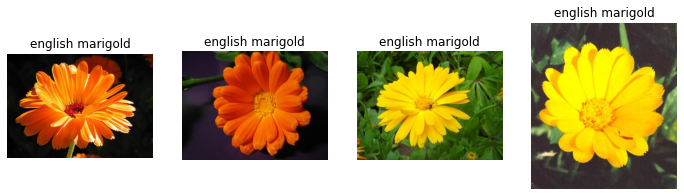

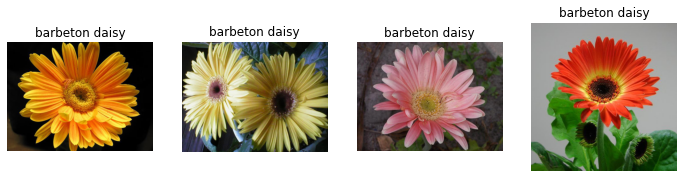

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["english marigold"]), plot_figure_by_class(df, NAMES_ID["barbeton daisy"])  

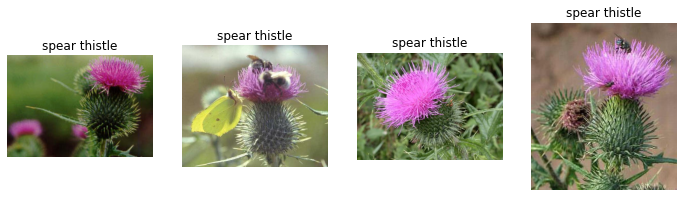

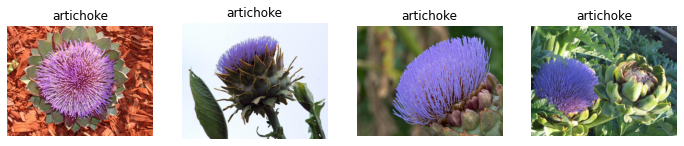

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["spear thistle"]), plot_figure_by_class(df, NAMES_ID["artichoke"]) 

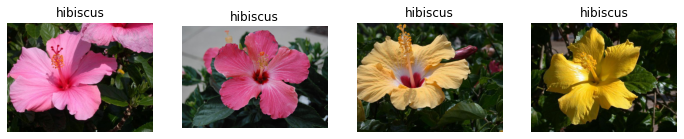

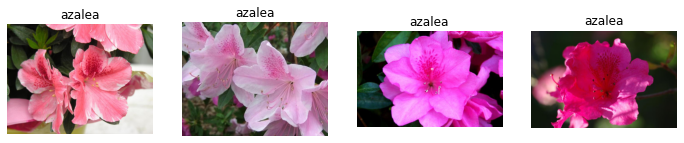

(None, None)

In [ ]:
plot_figure_by_class(df, NAMES_ID["hibiscus"]), plot_figure_by_class(df, NAMES_ID["azalea"])  

### Osservazioni  
La presenza di similarità tra alcune classi è un'altro problema da affrontare.    
Avendo poche immagini di training e considerando le limitazioni del data augmentation su un dataset sensibile a possibili distorsioni cromatiche si potrebbe considerare di estrarre **feature handcrafted** dalle nostre immagini, come complemento ad altre possibili features.
(considerazioni da rivalutare se fine tuning)

# Preprocessing & Data Augmentation
Data augmentation artificially increases the size of the training set by
generating many realistic variants of each training instance. This
reduces overfitting, making this a regularization technique. The
generated instances should be as realistic as possible: ideally, given an
image from the augmented training set, a human should not be able to
tell whether it was augmented or not. Simply adding white noise will
not help; the modifications should be learnable (white noise is not).

For example, you can slightly shift, rotate, and resize every picture in
the training set by various amounts and add the resulting pictures to the
training set. This forces the model to be more
tolerant to variations in the position, orientation, and size of the objects
in the pictures. For a model that’s more tolerant of different lighting
conditions, you can similarly generate many images with various
contrasts. In general, you can also flip the pictures horizontally (except
for text, and other asymmetrical objects). By combining these
transformations, you can greatly increase the size of your training set.

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean
(similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. Each category’s representation would be learned during training. This is an example of representation learning

**Contrast Augmentation:**

LAB color space expresses color variations across three channels. One channel for brightness and two channels for color:
- L-channel: representing lightness in the image
- a-channel: representing change in color between red and green
- b-channel: representing change in color between yellow and blue

In the following adaptive histogram equalization id performed on the L-channel and the resulting image is converted back to RGB color space. This enhances the brightness while also limiting contrast sensitivity

In [ ]:
def contrast_augmentation(img):

    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Stacking the original image with the enhanced image
    return np.hstack((img, enhanced_img))

In [ ]:
## remoto to execute
%%script false --no-raise-error

from keras.preprocessing.image import ImageDataGenerator

def oversample(df, n, dir, img_size):
    
    tmp_df=df.copy()
    tmp_df["Id"] = dir+tmp_df["Id"]
    
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(rescale=1. / 255, 
                                rotation_range = 50,
                                shear_range=0.2,
                                zoom_range=[0.75,1.25],
                                brightness_range=[0.5, 1.5],
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True)
                                # preprocessing_function = contrast_augmentation)

    groups=tmp_df.groupby('Category') # group by class

    for label in tmp_df['Category'].unique():  # for every class               
        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        
        if sample_count< n: # if the class has less than target number of images
            
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images\n'.format(' ', str(label), str(delta))

            prefix = 'aug-'+str(label).zfill(3)+"-"

            # augmentation parameters
            # The second one, flow_from_dataframe will be very useful to us. 
            # It checks the path available on the dataframe and then automatically search for the image in train directory. 
            # Then it make the desired preprocessing steps available in ImageDataGenerator
            aug_gen=gen.flow_from_dataframe(group,  
                                            x_col='Id', y_col=None, 
                                            target_size=img_size,
                                            class_mode=None, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            save_to_dir=dir, 
                                            save_prefix=prefix, 
                                            color_mode='rgb',
                                            save_format='jpg')
            # print(msg, end='')
            
            # new images creation
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count

            # dataframe updating
            for file in os.listdir(dir):
                if file.startswith(prefix):
                    df.loc[df.index.max()+1] = [file, label]

    print('Total Augmented images created= ', total)
    return df

threshold=100
img_size=(224,224)
train_set = oversample(train_set, threshold, "/content/jpg/", img_size)

In [ ]:
train_set

,Id,Category
6764,image_06765.jpg,0
6754,image_06755.jpg,0
6767,image_06768.jpg,0
6735,image_06736.jpg,0
6743,image_06744.jpg,0
...,...,...
8003,image_08004.jpg,101
8012,image_08013.jpg,101
8025,image_08026.jpg,101
8035,image_08036.jpg,101


In [ ]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
#                                     # preprocessing_function = contrast_augmentation)

# val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [ ]:
# # converting back to string because CNNs need a categorical input
# train_set['Category'] = train_set['Category'].astype(str)
# # test_set['Category']= test_set['Category'].astype(str)
# val_set['Category'] = val_set['Category'].astype(str)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_set,
#     directory=PATH_JPG,
#     x_col="Id",
#     y_col="Category",
#     target_size=(IMG_SIZE, IMG_SIZE),
#     # batch_size=BATCH_SIZE, # 32 default
#     class_mode='categorical',
#     shuffle=True, 
#     # seed=RANDOM_SEED,
#     )

# val_generator = val_datagen.flow_from_dataframe(
#     dataframe=val_set,
#     directory=PATH_JPG,
#     x_col="Id",
#     y_col="Category",
#     target_size=(IMG_SIZE, IMG_SIZE),
#     # batch_size=BATCH_SIZE, # 32 default
#     class_mode='categorical',
#     shuffle=False, 
#     # seed=RANDOM_SEED,
#     )

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=test_set,
#     directory=PATH_JPG,
#     x_col="Id",
#     y_col="Category",
#     target_size=(IMG_SIZE, IMG_SIZE),
#     # batch_size=BATCH_SIZE, # 32 default
#     class_mode='categorical',
#     shuffle=False, 
#     # seed=RANDOM_SEED,
#     )

# train_generator, val_generator, test_generator

Found 1020 validated image filenames belonging to 102 classes.
Found 1020 validated image filenames belonging to 102 classes.


<ipython-input-27-9996ab574e0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['Category'] = train_set['Category'].astype(str)
<ipython-input-27-9996ab574e0a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set['Category'] = val_set['Category'].astype(str)


# BiT - Big Transfer

Transfer of pre-trained representations improves sample efficiency and simplifies hyperparameter tuning when training deep neural networks for vision. We revisit the paradigm of pre-training on large supervised datasets and fine-tuning the model on a target task. We scale up pre-training, and propose a simple recipe that we call Big Transfer (BiT). By combining a few carefully selected components, and transferring using a simple heuristic, we achieve strong performance on over 20 datasets. BiT performs well across a surprisingly wide range of data regimes -- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark (VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class, and 97.0% on CIFAR-10 with 10 examples per class. We conduct detailed analysis of the main components that lead to high transfer performance.

> Title: Big Transfer (BiT): General Visual Representation Learning 
>> Paper: https://arxiv.org/abs/1912.11370

> -- <cite>Alexander Kolesnikov, Lucas Beyer, Xiaohua Zhai, Joan Puigcerver, Jessica Yung, Sylvain Gelly, Neil Houlsby</cite>


Other sources:
- https://github.com/google-research/big_transfer
- https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html

In [ ]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import os
import os.path
from os import path
from google.colab import drive


drive.mount('/content/gdrive', force_remount=True)
PATH_PROJ = "/content/gdrive/MyDrive/AML-proj/" 
if not path.exists(PATH_PROJ):
  PATH_PROJ = "/content/gdrive/Shareddrives/AML-proj/"  # TODO: check if it is correct!

NUM_CLASSES = 102

Mounted at /content/gdrive


## Load Tensorflow Dataset

Number of flower types 102
Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149

Flower types full list:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion'

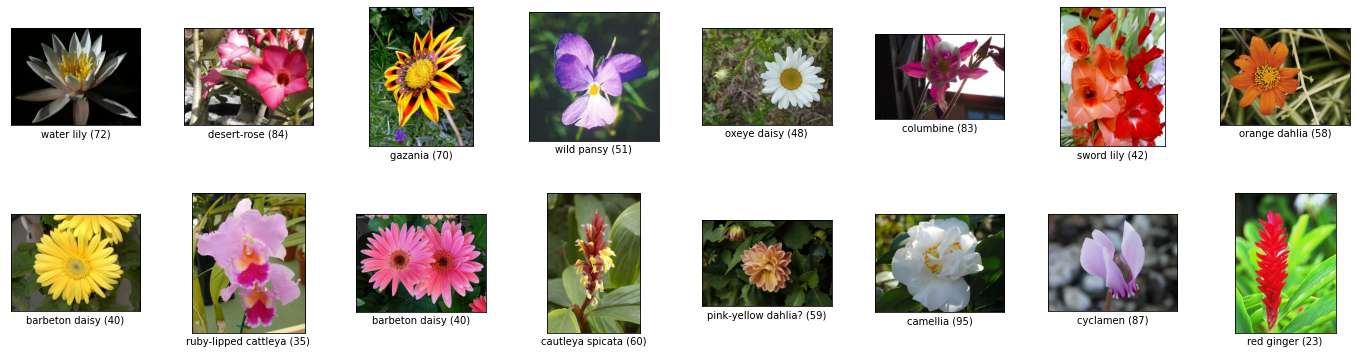

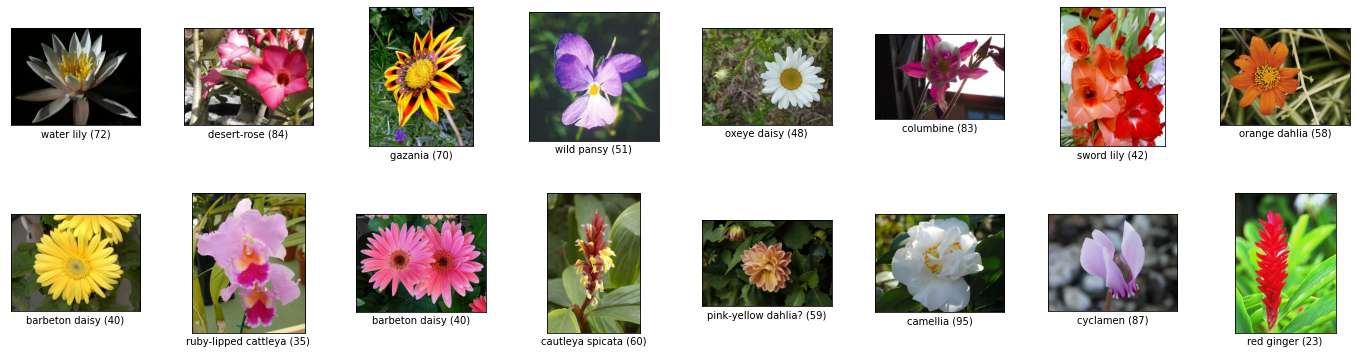

In [ ]:
ds_name = 'oxford_flowers102'
splits = ['test', 'train', 'validation']
ds, info = tfds.load(ds_name, split = splits, with_info=True)
(test_examples, train_examples, validation_examples) = ds
print(f"Number of flower types {info.features['label'].num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}\n")

print('Flower types full list:')
print(info.features['label'].names)

tfds.show_examples(train_examples, info, rows=2, cols=8)

In [ ]:
test_examples

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

## Model
Load a original model from: https://tfhub.dev/google/collections/bit/1
In this case we use a BiT-M model based on ResNet152x4 with pre-training on ImageNet-21k.It is less biased towards ImageNet-like images beacuase it is a "Feature extraction model".

In this project we saved our personal trained model on google-drive.

In [ ]:
# Load model into KerasLayer
%%script false --no-raise-error
# skip this cell, we saved the model

model_url = "https://tfhub.dev/google/bit/m-r152x4/1"
module = hub.KerasLayer(model_url)

In [ ]:
# Load saved model
ZIP_MODEL_PATH = PATH_PROJ + 'my_saved_BiT_model/50/bit_model.zip'
PB_PATH = "/content/content/bit_model/"
!unzip -o $ZIP_MODEL_PATH 

module = hub.KerasLayer(PB_PATH, trainable=True)

Archive:  /content/gdrive/MyDrive/AML-proj/my_saved_BiT_model/50/bit_model.zip
  inflating: content/bit_model/variables/variables.index  
  inflating: content/bit_model/variables/variables.data-00000-of-00001  
  inflating: content/bit_model/saved_model.pb  


## Fine-tuning the BiT model

Now we are going to fine-tune the BiT model so it performs better on Flowers102 dataset. We will use the model we loaded at the start so the model is less biased towards ImageNet-like images.

There are two steps:
1. Create a new model with a new final layer (which we call the ‘head’), and
2. Fine-tune this model using BiT-HyperRule, our hyperparameter heuristic.


### 1. Creating the new model



To create the new model, add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

#### Add new head to the BiT model

Since we want to use BiT on a new dataset (not the one it was trained on), we need to replace the final layer with one that has the correct number of output classes. This final layer is called the head.

Note that it is important to **initialise the new head to all zeros**.

In [ ]:
# Add new head to the BiT model

class FlowersBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    print(images)
    bit_embedding = self.bit_model(images)
    print(bit_embedding)
    return self.head(bit_embedding)


class FlowersBiTModelSaved(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, module):
    super().__init__()
    self.bit_model = module
  
  def call(self, images):
    return self.bit_model(images)
   




# model = FlowersBiTModel(NUM_CLASSES, module)
model = FlowersBiTModelSaved(module)

### Data and preprocessing


During fine-tuning, we use the following standard data pre-processing: we
resize the image to a square, crop out a smaller random square, and randomly
horizontally flip the image at training time. At test time, we only resize the
image to a fixed size.

#### BiT Hyper-Rule: hyperparameter selection heuristic
When we fine-tune the model, we use BiT-HyperRule like described in the original paper. It is the original heuristic for choosing hyperparameters for downstream fine-tuning. This is **not a hyperparameter sweep** - given a dataset, it specifies one set of hyperparameters that we’ve seen produce good results. You can often obtain better results by running a more expensive hyperparameter sweep, but BiT-HyperRule is an effective way of getting good initial results on your dataset.

**Hyperparameter heuristic details**

Following the istructions in the official paper:

To attain a low per-task adaptation cost, we do
not perform any hyperparameter sweeps downstream. Instead, we present BiTHyperRule, a heuristic to determine all hyperparameters for fine-tuning. Most
hyperparameters are fixed across all datasets, but schedule, resolution, and usage
of MixUp depend on the task’s image resolution and training set size.

- We had a problem with 512x512 resizing and 480x480 cropping. So we resize input images to 160 × 160 pixels, and then take a random crop of 128 × 128 pixels. We apply random crops and horizontal flips for all tasks
- Batch size 64 but the default value is 512 in the original work, so we modify few parameters. A way to adjust relevant parameters is to linearly scale the schedule length and learning rate. 
- We use SGD with an initial learning rate of 0.003, momentum 0.9.
- During fine-tuning, we decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps. 


In [ ]:
def percentage(percent, whole):
  return int((percent * whole) / 100.0)

def compute_schedule_boundaries(schedule_lenght):
  return [percentage(30, schedule_lenght), percentage(60, schedule_lenght), percentage(90, schedule_lenght)]

In [ ]:
RESIZE_TO = 160
CROP_TO = 128
BATCH_SIZE = 64
ORIGINAL_SCHEDULE_LENGTH = 500
# in every epoch (one full cycle through the training data) we make STEPS_PER_EPOCH steps
# in every step we process BATCH_SIZE samples
STEPS_PER_EPOCH = 10


DATASET_NUM_TRAIN_EXAMPLES = tf.data.experimental.cardinality(train_examples).numpy()
SCHEDULE_LENGTH = ORIGINAL_SCHEDULE_LENGTH * 512 / BATCH_SIZE 
SCHEDULE_BOUNDARIES = compute_schedule_boundaries(SCHEDULE_LENGTH)
SCHEDULE_BOUNDARIES, SCHEDULE_LENGTH

([1200, 2400, 3600], 4000.0)

In [ ]:
# Preprocessing helper functions

# Create data pipelines for training and testing:

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_validation(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [CROP_TO, CROP_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  
  return features


# """
# A sequence of data processing components is called a data pipeline. Pipelines are very
# common in machine learning systems, since there is a lot of data to manipulate and
# many data transformations to apply.
# Components typically run asynchronously. Each component pulls in a large amount
# of data, processes it, and spits out the result in another data store. Then, some time
# later, the next component in the pipeline pulls in this data and spits out its own
# output. Each component is fairly self-contained: the interface between components
# is simply the data store. This makes the system simple to grasp (with the help of a
# data flow graph), and different teams can focus on different components. Moreover,
# if a component breaks down, the downstream components can often continue to
# run normally (at least for a while) by just using the last output from the broken
# component. This makes the architecture quite robust.
# On the other hand, a broken component can go unnoticed for some time if proper
# monitoring is not implemented. The data gets stale and the overall system’s performance
# drops.
# """

pipeline_validation = (validation_examples.map(preprocess_validation, num_parallel_calls=tf.data.AUTOTUNE) 
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE) 
                  )


pipeline_test = (test_examples.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE) 
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE) 
                  )


# PIPELINE TRANSFORMATION
pipeline_train = (train_examples
                  # shuffle() will create a new
                  # dataset that will start by filling up a buffer with the first items of the source dataset.
                  # Then, whenever it is asked for an item, it will pull one out randomly from the buffer
                  # and replace it with a fresh one from the source dataset, until it has iterated entirely
                  # through the source dataset. At this point it will continue to pull out items randomly
                  # from the buffer until it is empty. You must specify the buffer size, and it is important
                  # to make it large enough, or else shuffling will not be very effective.1 Just don’t exceed
                  # the amount of RAM you have, though even if you have plenty of it, there’s no need
                  # to go beyond the dataset’s size. You can provide a random seed if you want the same
                  # random order every time you run your program.
                  .shuffle(10000)

                  # we first call the repeat() method on the original dataset, and it
                  # returns a new dataset that repeats the items of the original dataset N times. Of
                  # course, this will not copy all the data in memory N times!
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH))  # repeat dataset_size / num_steps

                  # This map() method is the one you will call to apply any preprocessing to your
                  # data. Sometimes this will include computations that can be quite intensive, such as
                  # reshaping or rotating an image, so you will usually want to spawn multiple threads to
                  # speed things up. This can be done by setting the num_parallel_calls argument to
                  # the number of threads to run, or to tf.data.AUTOTUNE.
                  .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE) 
                  
                  # Then we call the batch() method on this new dataset, and again this creates a new
                  # dataset. This one will group the items of the previous dataset in batches of N
                  # items.
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit

                  # Note that we use the prefetch() method on the very last line. This is important for performance
                  # By calling prefetch() at the end of the function,
                  # we are creating a dataset that will do its best to always be one batch ahead. In
                  # other words, while our training algorithm is working on one batch, the dataset will
                  # already be working in parallel on getting the next batch ready (e.g., reading the data
                  # from disk and preprocessing it). This can improve performance dramatically
                  .prefetch(tf.data.AUTOTUNE) 
                  )


### Fine-tuning loop



In [ ]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 # scale lr in relation with our batch size

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001]) # we decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps.

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
%%script false --no-raise-error
# skip this cell, we saved the model

# Fine-tune model
history = model.fit( 
  pipeline_train,
  batch_size=BATCH_SIZE,
  steps_per_epoch=STEPS_PER_EPOCH, # Total number of steps (batches of samples) before 
                                  # declaring one epoch finished and starting the next epoch. When training with input 
                                  # tensors such as TensorFlow data tensors, the default None is equal to the number of samples
                                  # in your dataset divided by the batch size, or 1 if that cannot be determined. If x is a tf.data dataset, 
                                  # and 'steps_per_epoch' is None, the epoch will run until the input dataset is exhausted. When passing an
                                  # infinitely repeating dataset, you must specify the steps_per_epoch argument. If steps_per_epoch=-1 the training will 
                                  # run indefinitely with an infinitely repeating dataset. This argument is not supported with array inputs.
  epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH), # we use few epochs only for TIME PROBLEMS
  validation_data=pipeline_validation  # here we are only using 
                                  # this data to evaluate our performance
)

### ------------- OUTPUT 
# Epoch 1/400
# 10/10 [==============================] - 144s 10s/step - loss: 4.2765 - accuracy: 0.1750 - val_loss: 3.3359 - val_accuracy: 0.5931
# Epoch 2/400
# 10/10 [==============================] - 80s 9s/step - loss: 2.5035 - accuracy: 0.7437 - val_loss: 1.4378 - val_accuracy: 0.9147
# Epoch 3/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.7050 - accuracy: 0.9797 - val_loss: 0.5372 - val_accuracy: 0.9755
# Epoch 4/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.1917 - accuracy: 0.9906 - val_loss: 0.3322 - val_accuracy: 0.9725
# Epoch 5/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.1120 - accuracy: 0.9922 - val_loss: 0.2535 - val_accuracy: 0.9784
# Epoch 6/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.2183 - val_accuracy: 0.9814
# Epoch 7/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0497 - accuracy: 1.0000 - val_loss: 0.1954 - val_accuracy: 0.9892
# Epoch 8/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0396 - accuracy: 1.0000 - val_loss: 0.1847 - val_accuracy: 0.9863
# Epoch 9/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0321 - accuracy: 1.0000 - val_loss: 0.1781 - val_accuracy: 0.9863
# Epoch 10/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.1731 - val_accuracy: 0.9853
# Epoch 11/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 0.1685 - val_accuracy: 0.9843
# Epoch 12/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.1634 - val_accuracy: 0.9863
# Epoch 13/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9863
# Epoch 14/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.1560 - val_accuracy: 0.9863
# Epoch 15/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.1532 - val_accuracy: 0.9873
# Epoch 16/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.1510 - val_accuracy: 0.9873
# Epoch 17/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.1489 - val_accuracy: 0.9882
# Epoch 18/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.1463 - val_accuracy: 0.9882
# Epoch 19/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.1443 - val_accuracy: 0.9873
# Epoch 20/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.1428 - val_accuracy: 0.9853
# Epoch 21/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.1405 - val_accuracy: 0.9853
# Epoch 22/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.1385 - val_accuracy: 0.9853
# Epoch 23/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.1367 - val_accuracy: 0.9863
# Epoch 24/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1352 - val_accuracy: 0.9863
# Epoch 25/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.1338 - val_accuracy: 0.9853
# Epoch 26/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9863
# Epoch 27/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.1313 - val_accuracy: 0.9873
# Epoch 28/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.1305 - val_accuracy: 0.9853
# Epoch 29/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9863
# Epoch 30/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 0.9873
# Epoch 31/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9882
# Epoch 32/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.1262 - val_accuracy: 0.9873
# Epoch 33/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1250 - val_accuracy: 0.9873
# Epoch 34/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1241 - val_accuracy: 0.9873
# Epoch 35/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.1231 - val_accuracy: 0.9863
# Epoch 36/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9882
# Epoch 37/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9863
# Epoch 38/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1207 - val_accuracy: 0.9863
# Epoch 39/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1199 - val_accuracy: 0.9873
# Epoch 40/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 0.9873
# Epoch 41/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.9863
# Epoch 42/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9873
# Epoch 43/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9873
# Epoch 44/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1165 - val_accuracy: 0.9863
# Epoch 45/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1160 - val_accuracy: 0.9873
# Epoch 46/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 0.9873
# Epoch 47/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9873
# Epoch 48/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 0.9873
# Epoch 49/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 0.9853
# Epoch 50/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 0.9853
# Epoch 51/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.1127 - val_accuracy: 0.9853
# Epoch 52/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1117 - val_accuracy: 0.9863
# Epoch 53/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9863
# Epoch 54/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.1108 - val_accuracy: 0.9863
# Epoch 55/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 0.9863
# Epoch 56/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1100 - val_accuracy: 0.9853
# Epoch 57/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1095 - val_accuracy: 0.9863
# Epoch 58/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.1092 - val_accuracy: 0.9853
# Epoch 59/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1089 - val_accuracy: 0.9853
# Epoch 60/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1085 - val_accuracy: 0.9863
# Epoch 61/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9863
# Epoch 62/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9863
# Epoch 63/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 0.9873
# Epoch 64/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1068 - val_accuracy: 0.9873
# Epoch 65/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9873
# Epoch 66/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1061 - val_accuracy: 0.9873
# Epoch 67/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1059 - val_accuracy: 0.9863
# Epoch 68/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9863
# Epoch 69/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1053 - val_accuracy: 0.9863
# Epoch 70/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1048 - val_accuracy: 0.9863
# Epoch 71/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1043 - val_accuracy: 0.9863
# Epoch 72/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1040 - val_accuracy: 0.9863
# Epoch 73/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1037 - val_accuracy: 0.9863
# Epoch 74/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1033 - val_accuracy: 0.9863
# Epoch 75/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9863
# Epoch 76/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1028 - val_accuracy: 0.9863
# Epoch 77/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1025 - val_accuracy: 0.9863
# Epoch 78/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1023 - val_accuracy: 0.9863
# Epoch 79/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.1019 - val_accuracy: 0.9863
# Epoch 80/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1015 - val_accuracy: 0.9853
# Epoch 81/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9853
# Epoch 82/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9853
# Epoch 83/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1006 - val_accuracy: 0.9853
# Epoch 84/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1004 - val_accuracy: 0.9863
# Epoch 85/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1003 - val_accuracy: 0.9863
# Epoch 86/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1002 - val_accuracy: 0.9863
# Epoch 87/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0999 - val_accuracy: 0.9863
# Epoch 88/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0998 - val_accuracy: 0.9863
# Epoch 89/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0997 - val_accuracy: 0.9863
# Epoch 90/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0993 - val_accuracy: 0.9863
# Epoch 91/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0990 - val_accuracy: 0.9863
# Epoch 92/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9863
# Epoch 93/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9863
# Epoch 94/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9863
# Epoch 95/400
# 10/10 [==============================] - 81s 9s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0981 - val_accuracy: 0.9863
# Epoch 96/400
# 10/10 [==============================] - 80s 9s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0980 - val_accuracy: 0.9863
# Epoch 97/400 ........
# CONTINUE ...


## Evaluate

We see that our model attains over 97-98% training and testing accuracy.

In [ ]:
score = model.evaluate(pipeline_test, batch_size=BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

97/97 [==============================] - 249s 2s/step - loss: 0.1602 - accuracy: 0.9774
Test loss: 0.16018687188625336
Test accuracy: 0.977394700050354


# Performance Summary

In [ ]:
def count_box_plot(unique_elem_dict, title, label):

  list_value=np.array(list(unique_elem_dict.values()))
  fig, ax = plt.subplots()
  # plt.figure(dpi=1200)

  # Save the chart so we can loop through the bars below.
  bars = ax.bar(range(len(unique_elem_dict)), list_value, align='center', tick_label=list(unique_elem_dict.keys()))

  # Axis formatting.
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)


  # Add labels and a title.
  ax.set_xlabel('Model type', labelpad=15, color='#333333')
  ax.set_ylabel(label, labelpad=15, color='#333333')
  ax.set_title(title, pad=15, color='#333333',
              weight='bold')

  plt.show()
  fig.savefig(PATH_PROJ + title + ".png", format="png", dpi=1200)


In [ ]:
PATH_PERFORMACES = PATH_PROJ + "performances.csv"
COL = ["Model", "Loss", "Accuracy", "AccuracyTop3"]
df = pd.read_csv(PATH_PERFORMACES)

df["AccuracyTop3"][3] = None
display(df)

df.to_latex(PATH_PROJ + "performances.tex")

<ipython-input-58-7e209a9c523c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["AccuracyTop3"][3] = None


,Model,Loss,Accuracy,AccuracyTop3
0,ResNet50,0.7039,0.8343,0.9228
1,ResNext101,0.7127,0.8787,0.9450
2,EfficientNetB3,0.3831,0.9083,0.9611
3,BigTransfer,0.1601,0.9773,NaN


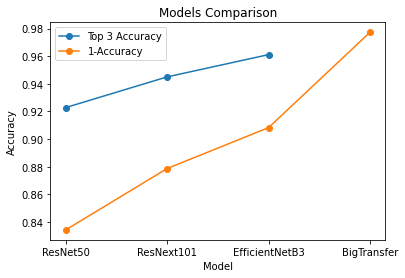

In [ ]:
top3 = np.array(df["AccuracyTop3"]).astype(np.double)
top3mask = np.isfinite(top3)

plt.plot(df["Model"][top3mask], top3[top3mask], linestyle='-', marker='o', label="Top 3 Accuracy")
plt.plot(df["Model"], df["Accuracy"], linestyle='-', marker='o', label="1-Accuracy")

plt.xlabel("Model")
plt.ylabel("Accuracy")

plt.legend()
title="Models Comparison"
plt.title(title)

plt.savefig(PATH_PROJ + title + ".png", format="png", dpi=1200)

plt.show()

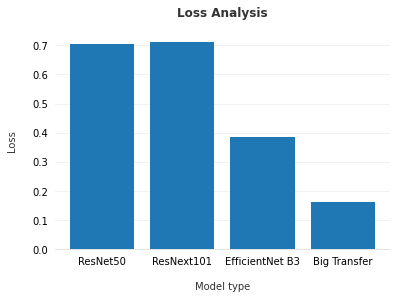

In [ ]:

count_box_plot(dict(zip(df["Model"], df[" Loss"])), "Loss Analysis", "Loss")

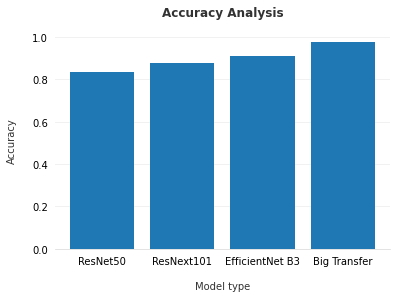

In [ ]:
count_box_plot(dict(zip(df["Model"], df[" Accuracy"])), "Accuracy Analysis", "Accuracy")